<a href="https://colab.research.google.com/github/phpaivamotta/fruit-recognition-deep-learning/blob/main/Copy_of_Bootcamp_Draft_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entrar no diretório

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Deep Learning em Python/Material/')

Mounted at /content/drive


## Leitura dos arquivos

In [ ]:
import glob
import cv2
import random
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
fruit_types = {'Apple':0, 'Banana':1, 'Pear':2, 'Pineapple':3, 'Grape':4, 'Cherry':5, 'Peach':6, 'Lemon':7, 'Cocos':8, 'Mango':9, 'Watermelon':10, 'Orange':11, 'Strawberry':12}

In [ ]:
all_train_files = [img_path for img_path in glob.glob('./Train/*/*.jpg') for fruit in fruit_types if fruit in img_path]
train_files, val_files = train_test_split(all_train_files, test_size=0.2, random_state=132)

In [ ]:
len(all_train_files)

26521

In [ ]:
len(train_files)

21216

In [ ]:
len(val_files)

5305

## Gerador

In [ ]:
def fruit_imgs_generator(files, batch_size=32):
  while True:
    batch_files = np.random.choice(files, size=batch_size)

    fruit_imgs = []
    fruit_labels = []
    for single_file in batch_files:
      fruit_infos = [(single_file,single_fruit_value) for single_fruit_type, single_fruit_value in fruit_types.items() if single_fruit_type in single_file]
      fruit_path = fruit_infos[0][0]
      fruit_type_value = fruit_infos[0][1]

      image = cv2.imread(fruit_path, cv2.IMREAD_COLOR)
      image = cv2.resize(image, (180,180))
                 
      image = cv2.normalize(image, 0, 1, norm_type=cv2.NORM_MINMAX)

      fruit_imgs.append(image)
      fruit_labels.append(fruit_type_value)
    
    batch_x = np.array(fruit_imgs)
    batch_y = np.array(fruit_labels)

    # usar quando one-hot encoded
    # batch_y = np.array(to_categorical(fruit_labels))

    yield (batch_x, batch_y)

In [ ]:
batch_size = 250

In [ ]:
img_train_gen = fruit_imgs_generator(files=train_files, batch_size=batch_size)
img_val_gen = fruit_imgs_generator(files=val_files, batch_size=batch_size)

In [ ]:
img_gen = fruit_imgs_generator(train_files, batch_size=batch_size)

In [ ]:
(batch_x, batch_y) = img_gen.__next__()
(batch_x.shape, batch_y.shape)

((250, 180, 180, 3), (250,))

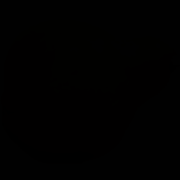

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(batch_x[0])

In [ ]:
X = batch_x
y = batch_y

In [ ]:
# Sem normalizar ou a normalização já embutida no gerador!
X_train = X

Testar com modelo simples CNN

In [ ]:
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Input
from keras.optimizers import Adam
from sklearn import metrics

In [ ]:
# original model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding="same", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(13, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

**Test model (Transfer learning)**

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

# freeze layers
for layer in vgg16.layers:
    layer.trainable = False

# Create a new input layer
input_layer = Input(shape=X_train.shape[1:])

# Connect the input layer to the pre-trained VGG16 model
vgg16_output = vgg16(input_layer)

flatten = Flatten()(vgg16_output)
dropout = Dropout(0.3)(flatten)
dense_1 = Dense(128, activation='relu')(dropout)
output_layer = Dense(13, activation='softmax')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 128)               1638528   
                                                                 
 dense_1 (Dense)             (None, 13)                1677      
                                                              

In [ ]:
steps_per_epoch = np.ceil(len(train_files) / batch_size)
validation_steps = np.ceil(len(val_files) / batch_size)
epochs = 4

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit_generator(img_train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=img_val_gen, validation_steps=validation_steps)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-20-51bd7d8e6003>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(img_train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=img_val_gen, validation_steps=validation_steps)


Epoch 1/4
85/85 [==============================] - 10916s 129s/step - loss: 0.5253 - accuracy: 0.8610 - val_loss: 0.0590 - val_accuracy: 0.9945
Epoch 2/4
71/85 [========================>.....] - ETA: 22:39 - loss: 0.0374 - accuracy: 0.9964

In [ ]:
y_pred = model.predict(X_train)

8/8 [==============================] - 3s 365ms/step


In [ ]:
# np.argmax(batch_y, axis=1)
batch_y

array([ 7,  0,  6,  5, 10,  6,  3,  0,  5,  5,  4,  9,  4,  6,  5,  8,  4,
        2, 10,  0,  2,  8,  0,  5,  9,  0,  1,  1,  4,  5,  0,  1,  1,  0,
        6,  0,  0,  1,  9,  9,  2,  5,  4,  7,  5,  3,  5,  0,  0,  6,  0,
        2,  0,  5, 12,  0,  6, 12, 12,  5,  0,  4,  5,  4,  6,  8,  0,  0,
        5,  2,  0, 12,  7,  0,  6,  2,  5,  2,  5,  0,  2,  2,  2,  8,  0,
        5, 12,  5,  4,  2, 11,  1, 10,  0,  0,  5,  6,  1,  2,  2,  5,  4,
        3,  0,  4,  2, 12,  0,  8,  0,  0,  0,  0,  6,  0,  5,  5,  2,  0,
        1,  6,  4,  5,  4,  2,  1,  5,  6,  3,  0,  5,  2,  0,  6,  4,  8,
        5,  5,  4, 12,  2,  6,  0,  0,  5,  5,  0,  3,  5,  0,  0,  0,  5,
        2,  5, 12,  0,  2,  1,  5,  0, 12,  0,  2,  3,  7,  4,  5,  1,  0,
        0,  2,  5,  2,  0,  4,  2,  3,  2,  5,  6, 12,  0, 10,  1,  5,  0,
        7,  2, 11,  2,  4,  6,  2,  8,  0,  2, 10,  4,  2,  0,  4,  2,  5,
        0,  5,  2,  5,  0, 10,  0,  6, 10,  0,  2,  6,  1,  2,  5,  0,  2,
        8, 11, 10,  5, 12

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

NameError: ignored

In [ ]:
np.argmax(y_pred, axis=1)

array([ 7,  0,  6,  5, 10,  6,  3,  0,  5,  5,  4,  9,  4,  6,  5,  8,  4,
        2, 10,  0,  2,  8,  0,  5,  9,  0,  1,  1,  4,  5,  0,  1,  1,  0,
        6,  0,  0,  1,  9,  9,  2,  5,  4,  7,  5,  3,  5,  0,  0,  6,  0,
        2,  0,  5, 12,  0,  6, 12, 12,  5,  0,  4,  5,  4,  6,  8,  0,  0,
        5,  2,  0, 12,  7,  0,  6,  2,  5,  2,  5,  0,  2,  2,  2,  8,  0,
        5, 12,  5,  4,  2, 11,  1, 10,  0,  0,  5,  6,  1,  2,  2,  5,  4,
        3,  0,  4,  2, 12,  0,  8,  0,  0,  0,  0,  6,  0,  5,  5,  2,  0,
        1,  6,  4,  5,  4,  2,  1,  5,  6,  3,  0,  5,  2,  0,  6,  4,  8,
        5,  5,  4, 12,  2,  6,  0,  0,  5,  5,  0,  3,  5,  0,  0,  0,  5,
        2,  5, 12,  0,  2,  1,  5,  0, 12,  0,  2,  3,  7,  4,  5,  1,  0,
        0,  2,  5,  2,  0,  4,  2,  3,  2,  5,  6, 12,  0, 10,  1,  5,  0,
        7,  2, 11,  2,  4,  6,  2,  8,  0,  2, 10,  4,  2,  0,  4,  2,  5,
        0,  5,  2,  5,  0, 10,  0,  6, 10,  0,  2,  6,  1,  2,  5,  0,  2,
        8, 11, 10,  5, 12

In [ ]:
y

array([ 7,  0,  6,  5, 10,  6,  3,  0,  5,  5,  4,  9,  4,  6,  5,  8,  4,
        2, 10,  0,  2,  8,  0,  5,  9,  0,  1,  1,  4,  5,  0,  1,  1,  0,
        6,  0,  0,  1,  9,  9,  2,  5,  4,  7,  5,  3,  5,  0,  0,  6,  0,
        2,  0,  5, 12,  0,  6, 12, 12,  5,  0,  4,  5,  4,  6,  8,  0,  0,
        5,  2,  0, 12,  7,  0,  6,  2,  5,  2,  5,  0,  2,  2,  2,  8,  0,
        5, 12,  5,  4,  2, 11,  1, 10,  0,  0,  5,  6,  1,  2,  2,  5,  4,
        3,  0,  4,  2, 12,  0,  8,  0,  0,  0,  0,  6,  0,  5,  5,  2,  0,
        1,  6,  4,  5,  4,  2,  1,  5,  6,  3,  0,  5,  2,  0,  6,  4,  8,
        5,  5,  4, 12,  2,  6,  0,  0,  5,  5,  0,  3,  5,  0,  0,  0,  5,
        2,  5, 12,  0,  2,  1,  5,  0, 12,  0,  2,  3,  7,  4,  5,  1,  0,
        0,  2,  5,  2,  0,  4,  2,  3,  2,  5,  6, 12,  0, 10,  1,  5,  0,
        7,  2, 11,  2,  4,  6,  2,  8,  0,  2, 10,  4,  2,  0,  4,  2,  5,
        0,  5,  2,  5,  0, 10,  0,  6, 10,  0,  2,  6,  1,  2,  5,  0,  2,
        8, 11, 10,  5, 12

In [ ]:
metrics.confusion_matrix(np.argmax(y_pred, axis=1), y)

array([[57,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 22,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 48,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11]])

Aplicar o modelo a base de teste

In [ ]:
all_test_files = [img_path for img_path in glob.glob('./Test/*.jpg')]

In [ ]:
len(all_test_files)

1000

In [ ]:
from natsort import natsorted

In [ ]:
# organizar arquivos em ordem ascendente
sorted_test_files = natsorted(all_test_files)

In [ ]:
# checar ordem dos arquivos
for i, file_name in enumerate(sorted_test_files):
  if i != int(file_name.split('_')[-1].split('.')[0]):
    print(i, int(file_name.split('_')[-1].split('.')[0]))
    break
  else:
    print(i, file_name)

0 ./Test/fruit_id_file_0.jpg
1 ./Test/fruit_id_file_1.jpg
2 ./Test/fruit_id_file_2.jpg
3 ./Test/fruit_id_file_3.jpg
4 ./Test/fruit_id_file_4.jpg
5 ./Test/fruit_id_file_5.jpg
6 ./Test/fruit_id_file_6.jpg
7 ./Test/fruit_id_file_7.jpg
8 ./Test/fruit_id_file_8.jpg
9 ./Test/fruit_id_file_9.jpg
10 ./Test/fruit_id_file_10.jpg
11 ./Test/fruit_id_file_11.jpg
12 ./Test/fruit_id_file_12.jpg
13 ./Test/fruit_id_file_13.jpg
14 ./Test/fruit_id_file_14.jpg
15 ./Test/fruit_id_file_15.jpg
16 ./Test/fruit_id_file_16.jpg
17 ./Test/fruit_id_file_17.jpg
18 ./Test/fruit_id_file_18.jpg
19 ./Test/fruit_id_file_19.jpg
20 ./Test/fruit_id_file_20.jpg
21 ./Test/fruit_id_file_21.jpg
22 ./Test/fruit_id_file_22.jpg
23 ./Test/fruit_id_file_23.jpg
24 ./Test/fruit_id_file_24.jpg
25 ./Test/fruit_id_file_25.jpg
26 ./Test/fruit_id_file_26.jpg
27 ./Test/fruit_id_file_27.jpg
28 ./Test/fruit_id_file_28.jpg
29 ./Test/fruit_id_file_29.jpg
30 ./Test/fruit_id_file_30.jpg
31 ./Test/fruit_id_file_31.jpg
32 ./Test/fruit_id_file_32.j

In [ ]:
fruit_types

{'Apple': 0,
 'Banana': 1,
 'Pear': 2,
 'Pineapple': 3,
 'Grape': 4,
 'Cherry': 5,
 'Peach': 6,
 'Lemon': 7,
 'Cocos': 8,
 'Mango': 9,
 'Watermelon': 10,
 'Orange': 11,
 'Strawberry': 12}

In [ ]:
results = {}

for i, test_file_path in enumerate(sorted_test_files):
  print(test_file_path)
  image = cv2.imread(test_file_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (180,180))
  image = cv2.normalize(image, 0, 1, norm_type=cv2.NORM_MINMAX)

  image = np.expand_dims(image, 0)

  output_class_value = model.predict(image)
  output_class_value = np.argmax(output_class_value, axis=1)
  

  results[i] = list(fruit_types.keys())[list(fruit_types.values()).index(output_class_value)]

./Test/fruit_id_file_0.jpg
1/1 [==============================] - 0s 37ms/step
./Test/fruit_id_file_1.jpg
1/1 [==============================] - 0s 32ms/step
./Test/fruit_id_file_2.jpg
1/1 [==============================] - 0s 32ms/step
./Test/fruit_id_file_3.jpg
1/1 [==============================] - 0s 34ms/step
./Test/fruit_id_file_4.jpg
1/1 [==============================] - 0s 31ms/step
./Test/fruit_id_file_5.jpg
1/1 [==============================] - 0s 30ms/step
./Test/fruit_id_file_6.jpg
1/1 [==============================] - 0s 31ms/step
./Test/fruit_id_file_7.jpg
1/1 [==============================] - 0s 34ms/step
./Test/fruit_id_file_8.jpg
1/1 [==============================] - 0s 32ms/step
./Test/fruit_id_file_9.jpg
1/1 [==============================] - 0s 35ms/step
./Test/fruit_id_file_10.jpg
1/1 [==============================] - 0s 31ms/step
./Test/fruit_id_file_11.jpg
1/1 [==============================] - 0s 32ms/step
./Test/fruit_id_file_12.jpg
1/1 [=================

In [ ]:
import csv

with open('arquivos_sorted_5_epochs.csv', 'w') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(['Id', 'Category'])
  for key, value in results.items():
    writer.writerow([key, value])